### basic gradient optimization problem
https://mitsuba.readthedocs.io/en/latest/src/inverse_rendering/gradient_based_opt.html

In [36]:
import drjit as dr
import mitsuba as mi

if you open any of the scene xml files, there's some paramaters at the top:
```xml
<default name="spp" value="128"/>
<default name="res" value="256"/>
<default name="max_depth" value="6"/>
<default name="integrator" value="path"/>
```
you can change these when loading the file into memory by passing in additional params to ```load_file()```.

here we set the resolution to 128 and change the integrator to the Path Replay Backpropagation integrator (PRB). Do I know what PRB is? nope, not yet. we'll see if I figure it out later or not

In [37]:
mi.set_variant('llvm_ad_rgb')
scene = mi.load_file('../scenes/cbox.xml', res = 128, integrator = 'prb')

In [38]:
image_ref = mi.render(scene, spp=512)
mi.Bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

the ```traverse()``` can be used to inspect any mitsuba object, and returns an instance of SceneParamaters.

In [39]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------------
  Name                                       Flags    Type           Parent
  ----------------------------------------------------------------------------------------------
  sensor.near_clip                                    float          PerspectiveCamera
  sensor.far_clip                                     float          PerspectiveCamera
  sensor.shutter_open                                 float          PerspectiveCamera
  sensor.shutter_open_time                            float          PerspectiveCamera
  sensor.film.size                                    ScalarVector2u HDRFilm
  sensor.film.crop_size                               ScalarVector2u HDRFilm
  sensor.film.crop_offset                             ScalarPoint2u  HDRFilm
  sensor.x_fov                               ∂, D     Float          PerspectiveCamera
  sensor.principal_point_offset_x            ∂,

we'll use this to modify the albedo color of the red wall in the scene

In [40]:
key = 'red.reflectance.value'
#save original value
param_ref = mi.Color3f(params[key])

#pick another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update();

In [41]:
image_init = mi.render(scene, spp = 512)
mi.Bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

mitsuba comes with stochastic gradient descent (SGD) with and without momentum, as well as Adam (KB14). basically, some more stuff that I don't understand yet.

start by instantiating Adam with a learning rate of 0.05.

then set the color to optimize on the optimizer, which will now hold a copy of this parameter and enable gradient tracking on it. during optimization process, the optimizer will always perform gradient steps on those variables

to propagate those changes to the scene, we'll call the ```update()``` method which will copy the values back into the params ```params``` data structure. this method also notifies all objects in the scene whose parameters have changed, in case they need to update their internal state.

more stuff that I don't understand yet, but they've got a "detailed explanation" of how to use the optimizer classes [here](https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/use_optimizers.html)

In [42]:
opt = mi.ad.Adam(lr=0.05)
opt[key] = params[key]
params.update(opt);

after every iteration of gradient descent, we will compute the derivatives of the scene params with respect to the objective function. in this example, we use the mean square error

In [43]:
def mse(image):
    return dr.mean(dr.sqr(image-image_ref))

define the hyper parameters controlling our optimization loop, i.e. number of iterations

In [44]:
iteration_count = 50

perform gradient-descent loop:

In [45]:
errors = []
for it in range(iteration_count):
    #perform a noisy differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)

    #eval the objective  function from current rendered image
    loss = mse(image)

    #backprop through the rendering process
    dr.backward(loss)

    #tell the optimizer to take a gradient descent step
    opt.step()

    #post process the optimized parameters to ensure legal color values (not 100% sure what this means yet)
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    #update the scene state to the new optimized values
    params.update(opt)

    #track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete')

Iteration 49: parameter error = 0.001432
Optimization complete


In [52]:
image_final = mi.render(scene, spp=512)
mi.Bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

plot error:

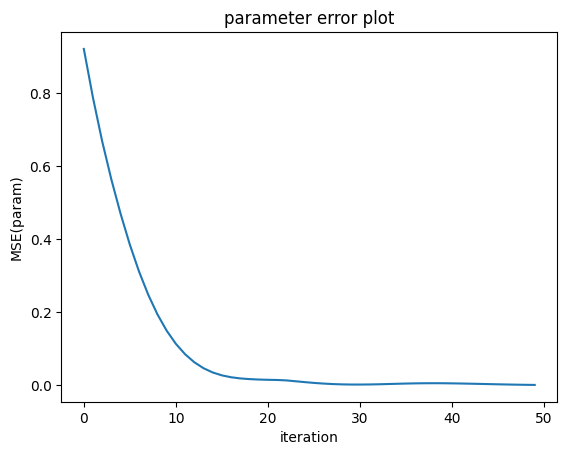

In [47]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('iteration');
plt.ylabel('MSE(param)');
plt.title('parameter error plot');
plt.show()

to show my learning, I wanted to produce a gif of the wall colour being optimized.

In [49]:
#pick another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update();

opt = mi.ad.Adam(lr=0.05)
opt[key] = params[key]
params.update(opt);

errors = []
for it in range(iteration_count):
    #perform a noisy differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)

    #save the noisy image:
    mi.util.write_bitmap(f"3_gradOptim/grad_optim{it}.png", image)

    #eval the objective  function from current rendered image
    loss = mse(image)

    #backprop through the rendering process
    dr.backward(loss)

    #tell the optimizer to take a gradient descent step
    opt.step()

    #post process the optimized parameters to ensure legal color values (not 100% sure what this means yet)
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    #update the scene state to the new optimized values
    params.update(opt)

    #track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete')

Iteration 49: parameter error = 0.001432
Optimization complete


In [54]:
mi.util.write_bitmap("3_gradOptim/image_final.png", image_final)
mi.util.write_bitmap("3_gradOptim/image_init.png", image_init)


Here's the compiled gif:

![SegmentLocal](3_result.gif "result")